In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
#%matplotlib inline
#import seaborn as sns; sns.set()
import numpy as np

from sys import platform as _platform

#if _platform =='linux2':
#    path = '../data/data_sleep/' 
#else:
    #mets ton path ici et ça devrait marcher :)
#    path = "data"
path="data/"

In [2]:
create_test = True
if(create_test):
    data=pd.read_csv(path+"input_test.csv")
else: 
    data=pd.read_csv(path+"input_train.csv")
    labels=pd.read_csv(path+"challenge_output_data_training_file_sleep_stages_classification.csv", sep=";")

In [3]:
def filt(y,low, high, freq): 
    filter_array = [i for i,f in enumerate(freq) if f>=low and f<=high]
    return np.array([y[i] for i in filter_array])

In [4]:
import re 
def make_eeg_features(train, low, high):
    fs = 250 # in Hz
    N = fs * 15
    train_eeg = train.filter(regex='EEG[0-9]*').values
    X_fft = np.fft.fft(train_eeg)
    freq = np.fft.fftfreq(N, 1./fs)
    filtered_freq = filt(freq,low,high,freq)
    X_fft = np.apply_along_axis(lambda x: filt(x,low,high,freq), 1 , 1./N * abs(X_fft))
    X_fft = pd.DataFrame(X_fft, columns= ["freq"+str(f) for f in filtered_freq])
    return X_fft

In [5]:
#X_fft = make_eeg_features(data, 0.4, 50)
#if(create_test):
#    X_fft.to_csv("data/fft_eeg_test.csv", index=False)
#else :
#    X_fft.to_csv("data/fft_eeg.csv", index=False)


In [6]:
def make_acc_features(train, low, high):
    fs = 10 #in Hz
    N = fs * 15 #number of samples
    accelaration_names = ['ACC_X.','ACC_Y.','ACC_Z.']
    result = []
    for name in accelaration_names:
        train_eeg = train.filter(regex=name+'[0-9]*').values
        X_fft = np.fft.fft(train_eeg)
        freq = np.fft.fftfreq(N, 1./fs)
        filtered_freq = filt(freq,low,high,freq)
        X_fft = np.apply_along_axis(lambda x: filt(x,low,high,freq), 1 , 1./N *abs(X_fft))
        X_fft = pd.DataFrame(X_fft, columns= [name+"freq"+str(f) for f in filtered_freq])
        result.append(X_fft)
    return pd.concat(result,axis = 1)

In [7]:
#fft_acc = make_acc_features(data, 0, 200)
#if(create_test):
#    fft_acc.to_csv("data/fft_acc_test.csv", index=False)
#else:
#    fft_acc.to_csv("data/fft_acc.csv", index=False)


In [8]:
def make_features_fft(create_test =False, make_files = True):
    #si create_test = False: fait les trucs de train, sinon les trucs de test
    #si make_files =True, crée les fichiers dans data
    X_fft = make_eeg_features(data, 0.4, 50)
    if(make_files):
        if(create_test):
            X_fft.to_csv("data/fft_eeg_test.csv", index=False)
        else :
            X_fft.to_csv("data/fft_eeg.csv", index=False)
    
    fft_acc = make_acc_features(data, 0, 200)
    if(make_files):    
        if(create_test):
            fft_acc.to_csv("data/fft_acc_test.csv", index=False)
        else:
            fft_acc.to_csv("data/fft_acc.csv", index=False)
    return X_fft, fft_acc

fft_eeg, fft_acc= make_features_fft(create_test = True)

In [9]:
def count_by_zero(array):
    """
    Counts the number of times the signal crosses through zero
    """
    counts = 0
    for i in range(0, len(array)-1):
        if np.sign(array[i]) != np.sign(array[i+1]):
            counts+=1
    return counts

In [10]:
def make_signal_dic(data):
    """
    Takes train or test data and creates a dictionary separating each signal
    """
    signals = ["EEG", "ACC_X", "ACC_Y", "ACC_Z"]
    return {signal: data.loc[:,data.columns.map(lambda x: x[:3]) == signal]
                     for signal in signals
    }

In [11]:
def create_stat_features(signal, signal_name):
    """
    Inputs a signal, outputs some important statistics information about it
    """

    quantiles = signal.quantile(np.linspace(0,1,11), axis=1).T
    quantiles.columns = ["{}_quantile_{}".format(signal_name, q) for q in range(0,110,10)]
    
    moments = pd.concat(
        [signal.mean(axis=1), signal.var(axis=1), signal.skew(axis=1), signal.kurt(axis=1)], 
        axis=1
    )
    moments.columns= [name.format(signal_name) for name in ["mean_{}", "var_{}", "skew_{}", "kurt_{}"]]
    
    return pd.concat([quantiles, moments], axis=1)

In [12]:
signals = make_signal_dic(data)

In [23]:
def make_stats(create_test =False, make_files = True):
    "takes the dict of signals and returns descriptive stats for EEG and ACC"
    stats = {
        signal: create_stat_features(signals[signal], signal)
        for signal in signals.keys()
    }
    stats_EEG = pd.concat(
        [
            stats["EEG"], 
            pd.Series(signals["EEG"].apply(count_by_zero, axis=1), name="EEG_through_0")
        ],
        axis=1
        )
    if make_files:
        if create_test:
            stats_EEG.to_csv("data/stats_eeg_test.csv", index=False)
        else:
            stats_EEG.to_csv("data/stats_eeg.csv", index=False)
    stats_ACC = pd.concat([stats["ACC_{}".format(dim)] for dim in ["X", "Y", "Z"]], axis=1)
    if make_files:
        if create_test:
            stats_ACC.to_csv("data/stats_acc_test.csv", index=False)
        else:
            stats_ACC.to_csv("data/stats_acc.csv", index=False)
    return stats_EEG, stats_ACC

In [24]:
stats_EEG, stats_ACC=make_stats(create_test =True, make_files = True)

In [25]:
def consolidated_amplitude_accelometer(fft_acc):
    """
    Takes the FFT of the accelerometer for each dimension. Returns the L2 norm of the amplitudes for each sequence
    """
    power_by_dimension = {dim: pd.DataFrame() for dim in ["X", "Y", "Z"]}
    #go through every column
    for col in fft_acc.columns:
        #check which dimension it is related to
        if col[4]=="X":
            #squared of the amplitude for each frequency
            power_by_dimension["X"]["ACC_X_{}".format(col[6:])]=fft_acc[col]**2 
        elif col[4]=="Y":
            power_by_dimension["Y"]["ACC_Y_{}".format(col[6:])]=fft_acc[col]**2
        elif col[4]=="Z":
            power_by_dimension["Z"]["ACC_Z_{}".format(col[6:])]=fft_acc[col]**2
    return np.sqrt(power_by_dimension["X"] + power_by_dimension["Y"] + power_by_dimension["Z"])

In [31]:
def speed_accelerometer(dict_accelerometer):
    """
    Takes a dictionary with dataframes for each dimension of the accelerometer. Returns consolidated features 
    (Speed and 1D amplitude)
    """
    #Integral of the acceleration = speed
    return np.sqrt( #sqrt of the
        sum( #sum over
            [
                dict_accelerometer["ACC_{}".format(dim)].sum(axis=1)**2 
                #squared integral of the acceleration
                for dim in ["X", "Y", "Z"] #for each dimension
            ]
        ) 
        
    )

In [32]:
def make_features_accelerometer(create_test =False, make_files = True):
    ACC_feats = pd.concat(
        [
            consolidated_amplitude_accelometer(fft_acc), 
            pd.Series(speed_accelerometer(signals), name="SPEED")
        ],
        axis=1
        )
    if make_files:
        if create_test:
            ACC_feats.to_csv("data/ACC_feats_test.csv", index=False)
        else:
            ACC_feats.to_csv("data/ACC_feats.csv", index=False)
    return ACC_feats

In [34]:
%pdb

Automatic pdb calling has been turned ON


In [35]:
ACC_feats=make_features_accelerometer(create_test =True)

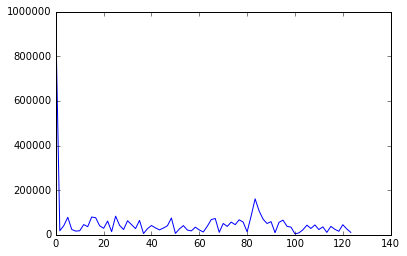

In [50]:
freq = np.fft.fftfreq(15*10, 1./250)
plt.plot(freq[0:75],result.values[0][0:75])

In [26]:
X_fft.values[0].shape,filt(np.fft.fftfreq(15*250, 1./250),0.4,50,np.fft.fftfreq(15*250, 1./250)).shape

((745,), (745,))

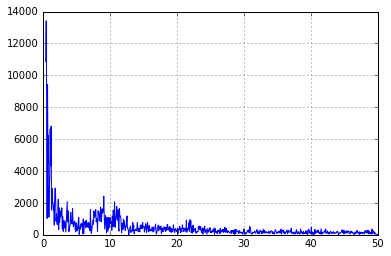

In [36]:
freq = np.fft.fftfreq(15*250, 1./250)
plt.plot(filt(freq,0.4,50,freq),np.abs(X_fft.values[31]))
plt.grid()
plt.show()